## <u>Introduction</u>

The dataframe consists of <b>162421</b> complaints for <b>5 products</b>. The dataframe is considerably <b>imbalanced</b>. 

The notebook implements <b>Bi-LSTM</b> model for <b>multiclass</b> classification of product complaints. Based on the provided <b>complaints</b>, the goal of the notebook is to accurately <b>identify the product</b>.    

## <u>Table of Contents</u>
*  [1. Reading and Analyzing Dataframe](#1)
*  [2. Train-Test Splitting](#2)
*  [3. Random Oversampling](#3)
*  [4. Text Preprocessing](#4)
*  [5. Label Encoding](#5)
*  [6. Tokenizing Sentences and Fixing Sentence Length](#6)
*  [7. Bi-LSTM Model](#7)
*  [8. Model Evaluation](#8)
*  [9. References](#9)

# Libraries

In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.client import device_lib
tf.test.gpu_device_name()

''

# 1. Reading and Analysing DataFrame

In [4]:
# Reading dataframe
df = pd.read_csv('C:/Users/Saicharitha/Desktop/7th SEM/NLP/complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [5]:
# Renaming columns 
df = df.rename(columns={'narrative':'tweet' })

# Removing SNo column
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,product,tweet
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [6]:
# Analysing dataframe attributes 
print('* Size of dataframe: {}\n'.format(df.shape))
print('* Datatype of columns are:\n {}\n'.format(df.dtypes))
print('* Count of different product categories:\n {}\n'.format(df['product'].value_counts()))
print('* Number of NaNs among tweets are: {}\n'.format(df['tweet'].isnull().sum())) 

* Size of dataframe: (162421, 2)

* Datatype of columns are:
 product    object
tweet      object
dtype: object

* Count of different product categories:
 credit_reporting       91179
debt_collection        23150
mortgages_and_loans    18990
credit_card            15566
retail_banking         13536
Name: product, dtype: int64

* Number of NaNs among tweets are: 10



In [7]:
# Removing NaNs
df = df.dropna(subset=['tweet'])
print('NaNs are removed from the dataframe. Number of NaNs can be confirmed to be {}. The size of dataframe has reduced to {}'.format(df['tweet'].isnull().sum(), df.shape))

NaNs are removed from the dataframe. Number of NaNs can be confirmed to be 0. The size of dataframe has reduced to (162411, 2)


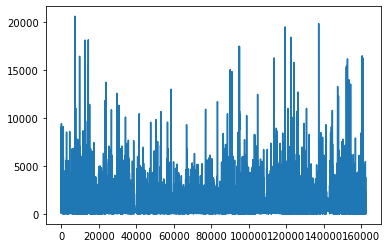

In [8]:
# Plotting word lenghts of tweets
word_length = [len(x) for x in df['tweet']]
plt.plot(word_length)

In [9]:
# Converting sentences to string
df['tweet'] = df['tweet'].astype(str)

In [10]:
# Types of products
df['product'].value_counts()

credit_reporting       91172
debt_collection        23148
mortgages_and_loans    18990
credit_card            15566
retail_banking         13535
Name: product, dtype: int64

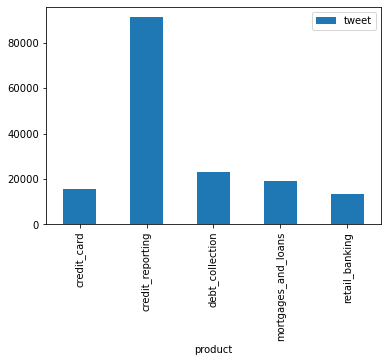

In [11]:
# Plotting product value counts
df.groupby('product').count().plot(kind='bar')
plt.show()

Dataframe is <b>imbalanced</b>. Improving the balance of the dataframe can improve <b>accuracy</b>.

# 2. Train-Test Splitting

In [12]:
# Importing train test splilt library 
from sklearn.model_selection import train_test_split

# Train-Test Splitting
train_data, test_data = train_test_split(df, test_size = 0.20)

In [13]:
# Train and test data dimensions
train_data.shape, test_data.shape

((129928, 2), (32483, 2))

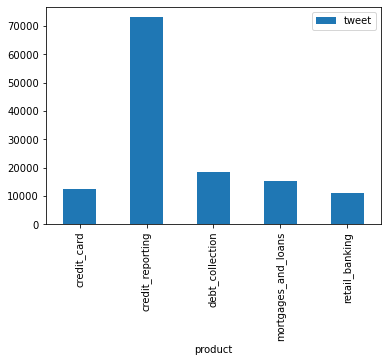

In [14]:
# Balance of train data
train_data.groupby('product').count().plot(kind='bar')
plt.show()

* credit_card, debt_collection, mortgages_and_loans, retail_banking columns consist of <b>very few values</b>. So, the values in these columns will be increased using <b>random oversampling</b>.
* Oversampling is done in train set because this will prevent <b>data leakage</b> to test set.  

# 3. Random Oversampling

In [15]:
# Train set value counts 
train_data.groupby('product').count()

,tweet
product,
credit_card,12416
credit_reporting,73039
debt_collection,18351
mortgages_and_loans,15175
retail_banking,10947


In [16]:
# Randomly selecting 7000 indices in classes with low value count
import numpy as np
to_add_1 = np.random.choice(train_data[train_data['product']=='credit_card'].index,size = 7000,replace=False)   
to_add_2 = np.random.choice(train_data[train_data['product']=='debt_collection'].index,size = 7000,replace=False) 
to_add_3 = np.random.choice(train_data[train_data['product']=='mortgages_and_loans'].index,size = 7000,replace=False)  
to_add_4 = np.random.choice(train_data[train_data['product']=='retail_banking'].index,size=7000,replace=False)

# Indices to be added
to_add = np.concatenate((to_add_1, to_add_2, to_add_3, to_add_4 ))
len(to_add)

28000

In [17]:
# Forming a dataframe for randomly selected indices
df_replicate = train_data[train_data.index.isin(to_add)]
df_replicate  

,product,tweet
48953,credit_card,store card amazon thru synchrony bank went acc...
102689,mortgages_and_loans,navient using unfair business practice inaccur...
64140,credit_card,logged call citibank regarding credit account ...
90901,retail_banking,large ach withdraws business account totaling ...
24598,mortgages_and_loans,hello utilized loan deferral option well fargo...
...,...,...
94473,debt_collection,kansa counselor attempting collect debt mine d...
121668,mortgages_and_loans,recently refinanced home loanunited sold loan ...
83169,credit_card,shocked reviewing credit report found late pay...
51471,retail_banking,dealing nonsense since fraudulently charged ac...


In [18]:
# Concatenating replicated df to orinigal df
train_data = pd.concat([train_data, df_replicate])
train_data['product'].value_counts()

credit_reporting       73039
debt_collection        25351
mortgages_and_loans    22175
credit_card            19416
retail_banking         17947
Name: product, dtype: int64

Value counts of minority classes have <b>increased</b>. 

# 4. Text Preprocessing

In [19]:
# Importing NLTK Libraries
import nltk
from nltk.corpus import stopwords
from nltk import *

In [20]:
# Declaring function for text preprocessing 

def preprocess_text(main_df):
  df_1 = main_df.copy()

  # remove stopwords
  nltk.download('stopwords')         # Downloading stopwords
  stop = stopwords.words('english')  
  df_1['tweet'] = df_1['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
  
  # remove punctuations and convert to lower case
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
  
  # remove double spaces
  df_1['tweet'] = df_1['tweet'].apply(lambda x: re.sub(' ', ' ', x))

  return df_1  

In [21]:
# Preprocessing training and test data 
train_data = preprocess_text(train_data)
test_data = preprocess_text(test_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saicharitha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saicharitha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# Verifying text preprocessing
train_data['tweet'].head()

161849    experian updated following account credit prof...
106805    applied sba relief fund denied credit score ca...
34863     applied credit card today approved called ask ...
32663     trying pay outstanding collection balance refl...
44732     capitol one card late paid card full card anym...
Name: tweet, dtype: object

# 5. Label Encoding

In [23]:
# Declaring train labels
train_labels = train_data['product'] 
test_labels = test_data['product']

In [24]:
# Converting labels to numerical features
import numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

['credit_card' 'credit_reporting' 'debt_collection' 'mortgages_and_loans'
 'retail_banking']
(array([0, 1, 2, 3, 4]), array([19416, 73039, 25351, 22175, 17947], dtype=int64))
(array([0, 1, 2, 3, 4]), array([ 3150, 18133,  4797,  3815,  2588], dtype=int64))


In [25]:
# Changing labels to categorical features
import numpy as np
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import numpy as np

train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.array(test_labels))

# 6. Tokenizing Sentences and Fixing Sentence Length

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Defining training parameters
max_sequence_length = 170   
max_words = 2500   

# Tokenizing tweets/sentences wrt num_words
tokenizer = Tokenizer(num_words = max_words)  # Selects most frequent words 
tokenizer.fit_on_texts(train_data.tweet)      # Develops internal vocab based on training text
train_sequences = tokenizer.texts_to_sequences(train_data.tweet)  # converts text to sequence

test_sequences = tokenizer.texts_to_sequences(test_data.tweet)

In [27]:
# Fixing the sequence length 
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_data = pad_sequences(train_sequences, maxlen = max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen = max_sequence_length)
train_data.shape, test_data.shape

((157928, 170), (32483, 170))

# 7. Bi-LSTM Model

## # 7.1 Declaring Model

In [28]:
# Model Parameters
embedding_dim = 32  

In [29]:
# Importing Libraries

import tensorflow as tf
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding 

In [30]:
embedding_dim = 32  

# Model Training
model = Sequential()
model.add(Embedding(max_words, 
                   embedding_dim,
                   input_length=max_sequence_length))

# Bidirectional LSTM 
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.4, recurrent_dropout=0)))   

model.add(GlobalMaxPool1D())

model.add(Dense(5,activation='softmax'))  

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 170, 32)           80000     
_________________________________________________________________
bidirectional (Bidirectional (None, 170, 32)           6272      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 86,437
Trainable params: 86,437
Non-trainable params: 0
_________________________________________________________________


## # 7.2 Passing Data Through Network

In [31]:
model.compile(loss = 'binary_crossentropy', optimizer='RMSProp', metrics = ['accuracy'])   

In [32]:
# declaring weights of product categories
class_weight = {0: 4,          
                1: 5,    
                2: 3,      
                3: 3,     
                4: 4}      

# training and validating model 
history = model.fit(train_data, train_labels, batch_size=48, epochs= 20, class_weight = class_weight, validation_data=(test_data, test_labels)) # best 89(now) or 48 or 60 epochs # default epochs = 23 # batch_size changed to 1 (takes 2.30hrs) from 16

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
3291/3291 [==============================] - 341s 102ms/step - loss: 0.9179 - accuracy: 0.7424 - val_loss: 0.1611 - val_accuracy: 0.8447
Epoch 2/20
3291/3291 [==============================] - 335s 102ms/step - loss: 0.5988 - accuracy: 0.8500 - val_loss: 0.1447 - val_accuracy: 0.8637
Epoch 3/20
3291/3291 [==============================] - 325s 99ms/step - loss: 0.5652 - accuracy: 0.8571 - val_loss: 0.1415 - val_accuracy: 0.8654
Epoch 4/20
3291/3291 [==============================] - 333s 101ms/step - loss: 0.5499 - accuracy: 0.8609 - val_loss: 0.1395 - val_accuracy: 0.8667
Epoch 5/20
3291/3291 [==============================] - 329s 100ms/step - loss: 0.5374 - accuracy: 0.8637 - val_loss: 0.1387 - val_accuracy: 0.8713
Epoch 6/20
3291/3291 [==============================] - 327s 99ms/step - loss: 0.5303 - accuracy: 0.8662 - val_loss: 0.1340

In [33]:
# Prediction on Test Data
predicted_bi_lstm = model.predict(test_data)
predicted_bi_lstm

array([[5.4066964e-05, 9.5454482e-03, 9.8960274e-01, 7.5379293e-04,
        4.4042863e-05],
       [9.5676637e-01, 2.2219934e-03, 3.2103743e-04, 3.5908415e-05,
        4.0654551e-02],
       [9.9968779e-01, 4.7313049e-05, 2.2248314e-04, 1.0181150e-05,
        3.2276945e-05],
       ...,
       [2.6917392e-06, 9.9993145e-01, 5.4152344e-05, 7.5257644e-06,
        4.1508933e-06],
       [1.1065241e-04, 1.6673800e-03, 6.6825969e-04, 9.9745196e-01,
        1.0167941e-04],
       [1.1484627e-06, 9.9996340e-01, 3.2823686e-05, 1.6042965e-06,
        1.1020627e-06]], dtype=float32)

# 8. Model Evaluation

## #8.1Model Performance Attributes

In [34]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(test_labels, predicted_bi_lstm.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('################################')
print(sklearn.metrics.classification_report(test_labels, predicted_bi_lstm.round()))

precision: [0.79301423 0.91606844 0.83118675 0.8860424  0.83250178]
recall: [0.7784127  0.93597309 0.75338753 0.7887287  0.90262751]
fscore: [0.78564563 0.9259138  0.79037726 0.83455831 0.86614757]
support: [ 3150 18133  4797  3815  2588]
################################
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      3150
           1       0.92      0.94      0.93     18133
           2       0.83      0.75      0.79      4797
           3       0.89      0.79      0.83      3815
           4       0.83      0.90      0.87      2588

   micro avg       0.88      0.87      0.88     32483
   macro avg       0.85      0.83      0.84     32483
weighted avg       0.88      0.87      0.88     32483
 samples avg       0.87      0.87      0.87     32483



C:\Users\Saicharitha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## #8.2 Model Performance with Epochs


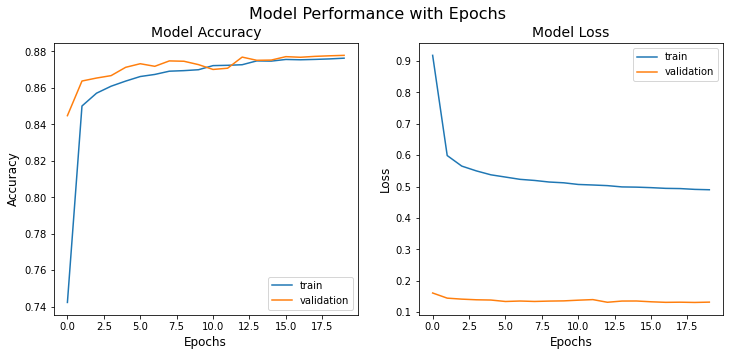

In [35]:
def accuracy_plot(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    fig.suptitle('Model Performance with Epochs', fontsize = 16)
    # Subplot 1 
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy', fontsize = 14)
    ax[0].set_xlabel('Epochs', fontsize = 12)
    ax[0].set_ylabel('Accuracy', fontsize = 12)
    ax[0].legend(['train', 'validation'], loc='best')
    
    # Subplot 2
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss', fontsize = 14)
    ax[1].set_xlabel('Epochs', fontsize = 12)
    ax[1].set_ylabel('Loss', fontsize = 12)
    ax[1].legend(['train', 'validation'], loc='best')
    
    
accuracy_plot(history)

## #8.3 Confusion Matrix

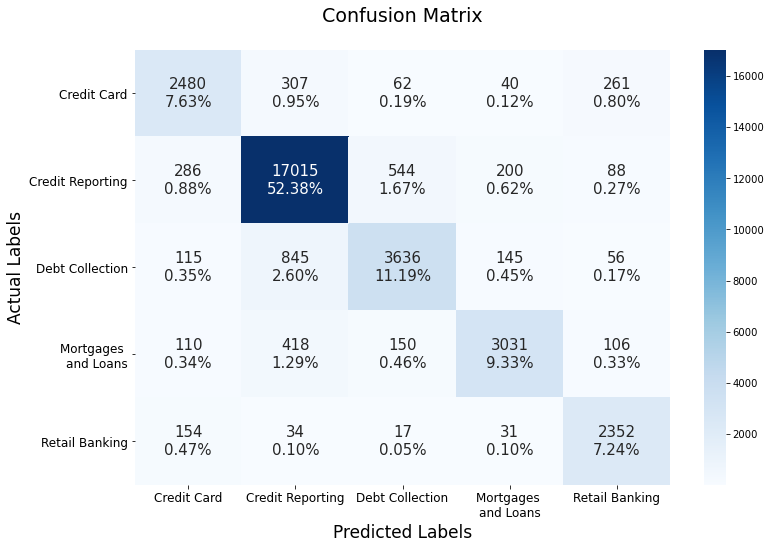

In [36]:
# Declaring function for plotting confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(model, test_data, test_labels):
    
    products = ['Credit Card', 'Credit Reporting', 'Debt Collection', 'Mortgages \nand Loans', 'Retail Banking']
        
    # Calculate predictions
    pred = model.predict(test_data)
    
    # Declaring confusion matrix
    cm = confusion_matrix(np.argmax(np.array(test_labels),axis=1), np.argmax(pred, axis=1))
    
    # Heat map labels

    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(5,5)

    # Plotting confusion matrix
    plt.figure(figsize=(12,8))
    
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=labels, annot_kws={"size": 15}, fmt = '',
                xticklabels = products,
                yticklabels = products)
    
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12, rotation = 'horizontal')
    plt.title('Confusion Matrix\n', fontsize=19)
    plt.xlabel('Predicted Labels', fontsize=17)
    plt.ylabel('Actual Labels', fontsize=17)
    
plot_cm(model, test_data, test_labels)

Model <b>accuracy</b> is verified with confusion matrix. 